# Exploring the Dataset

In this section, I'll be doing some inital exploration of the MRI scans dataset.

In [8]:
glioma_train_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\testing\glioma"

Loaded 300 images.


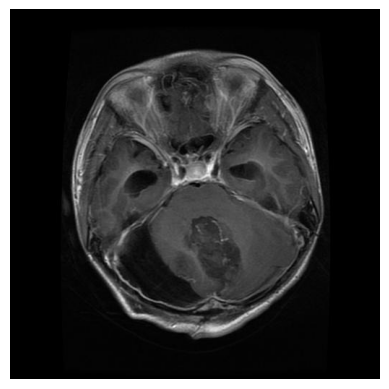

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt


folder_path = glioma_train_path  

# List to hold all loaded images
images = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        # Open and load the image
        img = Image.open(file_path)
        # Append the image object to the list
        images.append(img)

# Now `images` contains all opened jpg images from the folder
print(f"Loaded {len(images)} images.")

# Display the first image in the Jupyter Notebook
if images:  # Check if the list is not empty
    plt.imshow(images[0])  # Display the first image
    plt.axis('off')  # Hide axis for a cleaner look
    plt.show()
